In [43]:
import numpy as np
import pandas as pd
from scipy.optimize import basinhopping
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import log_loss
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce

%matplotlib inline

In [113]:
seed = 12
X, y = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, random_state=seed)

mms = MinMaxScaler()
X_ss = mms.fit_transform(X)

x1, x2 = X[:, 0].reshape(1, -1)[0], X[:, 1].reshape(1, -1)[0]

In [114]:
def plot_decision_boundary(X, y, model, scale=True):
    if scale:
        ss = StandardScaler()
        X = ss.fit_transform(X)
    
    model.fit(X, y)
    
    plot_step = 0.02
    plot_step_coarser = 0.5

    # Now plot the decision boundary using a fine mesh as input to a
    # filled contour plot
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    grid = np.c_[xx.ravel(), yy.ravel()]
    probs = model.predict_proba(grid)[:, 1].reshape(xx.shape)

    f, ax = plt.subplots(figsize=(8, 6))
    contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                          vmin=0, vmax=1)
    ax_c = f.colorbar(contour)
    ax_c.set_label("$P(y = 1)$")
    ax_c.set_ticks([0, .25, .5, .75, 1])

    ax.scatter(X[:,0], X[:, 1], c=y, s=50,
               cmap="RdBu", vmin=-.2, vmax=1.2,
               edgecolor="white", linewidth=1)

    ax.set(aspect="equal", xlabel="$x1$", ylabel="$x2$")
    
    return model

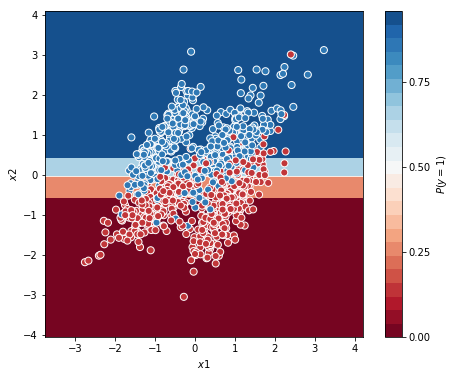

In [115]:
model = plot_decision_boundary(X, y, DecisionTreeClassifier(max_depth=2))

In [116]:
from sklearn.tree import _tree

def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print("{}return {}".format(indent, tree_.value[node]))

    recurse(0, 1)

In [117]:
tree_to_code(model, ['x1', 'x2'])

def tree(x1, x2):
  if x2 <= -0.0516947265714407:
    if x2 <= -0.5896345973014832:
      return [[285.  11.]]
    else:  # if x2 > -0.5896345973014832
      return [[141.  47.]]
  else:  # if x2 > -0.0516947265714407
    if x2 <= 0.40872861444950104:
      return [[ 57. 115.]]
    else:  # if x2 > 0.40872861444950104
      return [[ 19. 325.]]


In [122]:
def mybounds(**kwargs):
    x = kwargs["x_new"]
    tmax = bool(np.all(x <= 1.0))
    tmin = bool(np.all(x >= 0.0))
    return tmax and tmin

def f(x):
#     rules = [x1 > x[0], x2 < x[1]]
#     rule = reduce(lambda a, b: a & b, rules)
    return log_loss(y, (x2 > x[1]).astype(int))

def print_fun(x, f, accepted):
    print("at minimum %.4f accepted %d" % (f, int(accepted)))

In [123]:
result = basinhopping(f, [0.2, 0.3], niter=1000, accept_test=mybounds)

In [124]:
result

                        fun: 4.766394320758906
 lowest_optimization_result:       fun: 4.766394320758906
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 4
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0.83502658, 0.05743423])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 0
                       nfev: 4004
                        nit: 1000
                       njev: 1001
                          x: array([0.83502658, 0.05743423])

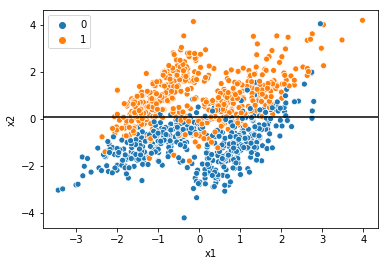

In [127]:
ax = sns.scatterplot(pd.Series(x1, name='x1'), pd.Series(x2, name='x2'), hue=y, )
# ax.axvline(result.x[0], c='black')
ax.axhline(result.x[1], c='black')